In [180]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.decomposition import PCA

In [181]:
def topdom_result_format(result_path,celline):
    print('run')
    result_list = []
    for index in range(1,24):
        filepath = "{0}/{1}_MboI_chr{2}_topdomResult.domain".format(result_path, celline, index)
        data = pd.read_csv(filepath, sep='\t')
        topre = np.array(data['from.id'])
        result_list.append(topre)
        print('lens of topdom:{0}'.format(len(topre)))
    return result_list
def di_result_format(result_path,celline):
    result_list = []
    for index in range(1,24):
        filepath = "{0}/{1}_50kb_chr{2}finaldomaincalls".format(result_path, celline, index)
        data = pd.read_csv(filepath, header=None, sep='\t')
        re = data.loc[:,1]/50000
        re = np.array(re, dtype=np.int).tolist()
        result_list.append(re)
        print('lens of di:{0}'.format(len(re)))
    return result_list
def insulation_result_format(result_path,celline):
    result_list = []
    for index in range(1,24):
        filepath = "{0}/{1}_MboI_chr{2}_ice.is500001.ids200001.insulation.boundaries".format(result_path,celline,index)
        data = pd.read_csv(filepath,sep='\t')
        strs = data['header.1']
        result = []
        for st in strs:
            spls = int(st.split('|')[0].replace('bin', ''))
            result.append(spls)
        print('lens of is:{0}'.format(len(result)))
        result_list.append(result)
    return result_list
def mctad_result_format(result_path, hold):
    print('run')
    result_list = []
    for index in range(1, 24):
        hold_list = []
        filepath = "{0}/chr{1}_min_score.txt".format(result_path, index)
        valuepath = "{0}/chr{1}_min_value.txt".format(result_path, index)
        reloca = np.loadtxt(filepath, dtype=np.int)
        rescore = np.loadtxt(valuepath)
        sort_rescore = np.sort(rescore)
        threshold = sort_rescore[int(len(sort_rescore)*hold)]
        for index in range(len(rescore)):
            if rescore[index] < threshold:
                hold_list.append(reloca[index])
        print('lens of mctad:{0}'.format(len(hold_list)))
        result_list.append(hold_list)
    return result_list
def Emtad_result_format(result_path):
    print('run')
    result_list = []
    for index in range(1,23):
        filepath = "{0}/chr{1}.txt".format(result_path, index)
        reloca = np.loadtxt(filepath, dtype=np.int)
        result_list.append(reloca[0:-1])

    return result_list
def hickey_result_format():
    result_list = []
    for index in range(1,23):
        filepath = "/mnt/disk1/duanran/GM12878/GM12878_combined/50kb_resolution_intrachromosomal/chr{0}/MAPQGE30/chr{1}_50kb_output.txt".format(index,index)
        data = pd.read_csv(filepath,sep='\t',header=None)
        # 0列除以分辨率
        data[0] = data[0]/50000
        # 0列转为np.array
        data[0] = data[0].apply(np.floor)
        data[0] = data[0].astype(int)
        # 0列转为list
        hic_key_result = data[0].tolist()
        hic_key_result = np.array(hic_key_result)
        result_list.append(hic_key_result)
    return result_list
def is_file_empty(file_path):
    with open(file_path, 'r') as file:
        return len(file.read()) == 0
def load_CI_list(mat_folder, celline):
    CI_list =[]
    for index in range(1,23):
        cifile = '{0}/{1}{2}_CIvalue'.format(mat_folder, celline, index)
        cci = np.loadtxt(cifile)
        CI_list.append(cci)
    return CI_list
def compare_biomaker_results(results_list,biomaker_list,length,mat_len_list):
    bio_result_list = []
    for id in range(len(results_list)):
        mat_length = mat_len_list[id]
        bio_result =[0]*11
        resu = results_list[id]
        bio = biomaker_list[id]
        count = 0
        for locaa in resu:
            loca = int(locaa)
            if loca > length and mat_length - length > loca:
                reloca = int(loca - 1)
                rr = np.array(bio[reloca-length:reloca+length+1])
                bio_result = bio_result+rr
                count +=1
        bio_result_list.append(bio_result/count)
    for bb in bio_result_list:
        print(np.max(bb))
    return bio_result_list
def compare_celline_lunkuoxishu(mat_folder, results, mat_length_list,celline):
    value_list = []
    for index in range(len(results)):
        mat = np.loadtxt("{0}/{1}{2}".format(mat_folder,celline,index+1))
        value = get_lunkuoxishu(mat, results[index], mat_length_list[index])
        value_list.append(value)
    return value_list
def get_lunkuoxishu(mat, results, mat_length):
    ice_mat = mat
    re = np.where(np.all(ice_mat == 0, axis=0))

    dele_mat = np.delete(ice_mat, re, axis=0)
    dele_mat = np.delete(dele_mat, re, axis=1)


    cl = 0
    begin = 0
    labels = results
    labels = np.append(labels,mat_length)
    lable_list=[]
    for rande in labels:
        for index in range(begin,rande):
            lable_list.append(cl)
        begin = rande
        cl += 1

    relist = np.array(lable_list)
    finale = np.delete(relist, re)
    # hic_mat = np.loadtxt(mat_path)[0:1600,0:1600]
    # hic_mat = original_matrix_to_ice_matrix(hic_mat)
    # print(np.shape(hic_mat))
    # print(np.shape(lable_list))
    # print(labels)
    # print(lable_list)

    pca = PCA(n_components=300)
    pca_dele_mat = pca.fit_transform(dele_mat)
    value = metrics.silhouette_score(pca_dele_mat, finale, metric='cosine')
    # ['euclidean', 'l2', 'l1', 'manhattan', 'cityblock', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine',
    #  'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao',
    #  'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule', 'wminkowski', 'nan_euclidean', 'haversine']
    return value

In [187]:
# 加载/mnt/disk3/duanran/zhaoshixiong/GSE63525_GM12878_primary+replicate_Arrowhead_domainlist.txt
resution = 50000
top_re_list = []
di_re_list = []
is_re_list = []
HiCDB_re_list = []
hickey_re_list = []
emd_re_list = []
for chr_num in range(1,23):
    aim_tad = pd.read_csv('/mnt/disk3/duanran/zhaoshixiong/GSE63525_GM12878_primary+replicate_Arrowhead_domainlist.txt',sep='\t')
    aim_tad
    # x1,x2,y1,y2除以resution
    aim_tad['x1'] = aim_tad['x1']/resution
    aim_tad['x2'] = aim_tad['x2']/resution
    aim_tad['y1'] = aim_tad['y1']/resution
    aim_tad['y2'] = aim_tad['y2']/resution
    
    # 保留chr1中2的数据
    aim_tad = aim_tad[aim_tad['chr1'] == '{0}'.format(chr_num)]
    # 输出最后10行
    aim_tad.tail(10)
    # 按照x1大小排序
    aim_tad = aim_tad.sort_values(by='x1')
    
    # x1,x2,y1,y2向下取整
    aim_tad['x1'] = aim_tad['x1'].apply(np.floor)
    aim_tad['x2'] = aim_tad['x2'].apply(np.floor)
    aim_tad['y1'] = aim_tad['y1'].apply(np.floor)
    aim_tad['y2'] = aim_tad['y2'].apply(np.floor)
    # x1,x2转为list
    x1 = aim_tad['x1'].tolist()
    x2 = aim_tad['x2'].tolist()
    
    flag = True
    outer_boundary = []
    bd_index = 0
    while flag:
        x1_boundary = x1[bd_index]
        x2_boundary = x2[bd_index]
        outer_boundary.append(x1_boundary)
        outer_boundary.append(x2_boundary)
        while x1[bd_index] < x2_boundary:
            bd_index += 1
            if bd_index == len(x1):
                flag = False
                break
    # 转为np.array并去重复
    outer_boundary = np.array(outer_boundary)
    outer_boundary = np.unique(outer_boundary)
    gold_tad_bd = outer_boundary
    
    celline = 'GM12878'
    topdom_result_list = topdom_result_format('/mnt/disk3/duanran/mactop/{0}_result/08.TopDom_Result'.format(celline), celline)
    topdom_result = topdom_result_list[chr_num-1]
    di_result_list = di_result_format('/mnt/disk3/duanran/mactop/{0}_result/02.DI_Result'.format(celline), celline)
    di_result = di_result_list[chr_num-1]
    is_result_list = insulation_result_format('/mnt/disk3/duanran/mactop/{0}_result/03.IS_Result'.format(celline), celline)
    is_result = is_result_list[chr_num-1]
    HiCDB_result_list = mctad_result_format('/home/rduan/utad/algorithm/{0}re'.format(celline), 0.95)
    HiCDB_result = HiCDB_result_list[chr_num-1]
    hickey_result_list = hickey_result_format()
    hickey_result = hickey_result_list[chr_num-1]
    EMtad_result_list = Emtad_result_format('/home/rduan/utad/algorithm/EMTAD_zhao_re')
    EMtad_result = EMtad_result_list[chr_num-1]
    
    
    # topdom_result和gold_tad_bd 相同的部分
    topdom_gold = np.intersect1d(topdom_result,gold_tad_bd)
    # di_result和gold_tad_bd 相同的部分
    di_gold = np.intersect1d(di_result,gold_tad_bd)
    # is_result和gold_tad_bd 相同的部分
    is_gold = np.intersect1d(is_result,gold_tad_bd)
    # HiCDB_result和gold_tad_bd 相同的部分
    HiCDB_gold = np.intersect1d(HiCDB_result,gold_tad_bd)
    # hickey_result和gold_tad_bd 相同的部分
    hickey_gold = np.intersect1d(hickey_result,gold_tad_bd)
    # EMtad_result和gold_tad_bd 相同的部分
    EMtad_gold = np.intersect1d(EMtad_result,gold_tad_bd)
    
    
    # 输出三个gold的长度
    print('topdom_gold:{0}-{1}'.format(len(topdom_gold)/len(topdom_result),len(topdom_result)))
    top_re_list.append([len(topdom_gold),len(topdom_gold)/len(topdom_result)])
    print('di_gold:{0}-{1}'.format(len(di_gold)/len(di_result),len(di_result)))
    di_re_list.append([len(di_gold),len(di_gold)/len(di_result)])
    print('is_gold:{0}-{1}'.format(len(is_gold)/len(is_result),len(is_result)))
    is_re_list.append([len(is_gold),len(is_gold)/len(is_result)])
    print('HiCDB_gold:{0}-{1}'.format(len(HiCDB_gold)/len(HiCDB_result),len(HiCDB_result)))
    HiCDB_re_list.append([len(HiCDB_gold),len(HiCDB_gold)/len(HiCDB_result)])
    print('hickey_gold:{0}-{1}'.format(len(hickey_gold)/len(hickey_result),len(hickey_result)))
    hickey_re_list.append([len(hickey_gold),len(hickey_gold)/len(hickey_result)])
    print('EMtad_gold:{0}-{1}'.format(len(EMtad_gold)/len(EMtad_result),len(EMtad_result)))
    emd_re_list.append([len(EMtad_gold),len(EMtad_gold)/len(EMtad_result)])

run
lens of topdom:509
lens of topdom:475
lens of topdom:377
lens of topdom:371
lens of topdom:351
lens of topdom:314
lens of topdom:309
lens of topdom:289
lens of topdom:236
lens of topdom:267
lens of topdom:271
lens of topdom:273
lens of topdom:184
lens of topdom:177
lens of topdom:173
lens of topdom:166
lens of topdom:173
lens of topdom:142
lens of topdom:116
lens of topdom:125
lens of topdom:61
lens of topdom:82
lens of topdom:259
lens of di:290
lens of di:181
lens of di:172
lens of di:149
lens of di:145
lens of di:138
lens of di:133
lens of di:125
lens of di:136
lens of di:107
lens of di:127
lens of di:141
lens of di:73
lens of di:67
lens of di:62
lens of di:98
lens of di:6
lens of di:68
lens of di:30
lens of di:39
lens of di:4
lens of di:19
lens of di:76
lens of is:450
lens of is:400
lens of is:333
lens of is:313
lens of is:288
lens of is:295
lens of is:259
lens of is:256
lens of is:233
lens of is:228
lens of is:243
lens of is:246
lens of is:153
lens of is:135
lens of is:165
lens

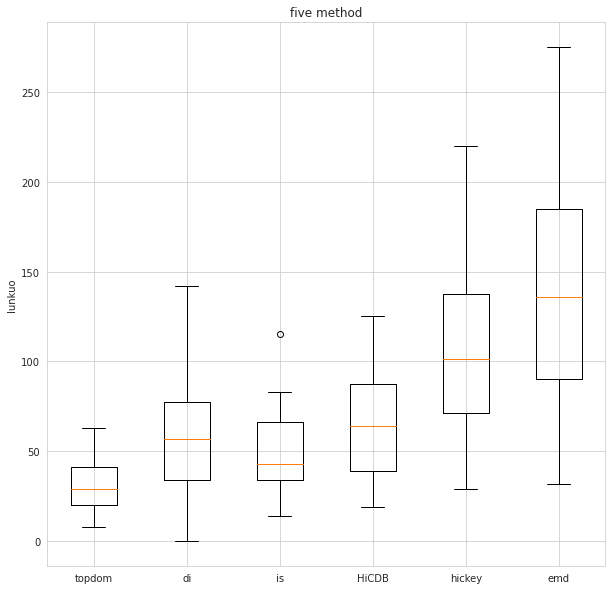

In [188]:
# 五个list画图
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 五个list画图
top_re_list = np.array(top_re_list)
di_re_list = np.array(di_re_list)
is_re_list = np.array(is_re_list)
HiCDB_re_list = np.array(HiCDB_re_list)
hickey_re_list = np.array(hickey_re_list)
emd_re_list = np.array(emd_re_list)

# 六个re_list 合并到datafream中
df = pd.DataFrame({'topdom':top_re_list[:,0],'di':di_re_list[:,0],'is':is_re_list[:,0],'HiCDB':HiCDB_re_list[:,0],'hickey':hickey_re_list[:,0],'emd':emd_re_list[:,0]})
# 保存到csv
df.to_csv('/mnt/disk3/duanran/zhaoshixiong/addition/zhao_re2.csv')

# 绘制boxplt
plt.figure(figsize=(10,10))
plt.boxplot([top_re_list[:,0],di_re_list[:,0],is_re_list[:,0],HiCDB_re_list[:,0],hickey_re_list[:,0],emd_re_list[:,0]],labels=['topdom','di','is','HiCDB','hickey','emd'])
plt.title('five method')
plt.ylabel('lunkuo')
plt.show()



In [192]:
celline = 'GM12878'
mat_len_list = np.loadtxt('/home/rduan/utad/algorithm/hunmen_gens_length', dtype=np.int)
insulation_list = load_CI_list('/mnt/disk1/duanran/{0}dense'.format(celline), celline)
topdom_result_list = topdom_result_format('/mnt/disk3/duanran/mactop/{0}_result/08.TopDom_Result'.format(celline), celline)
di_result_list = di_result_format('/mnt/disk3/duanran/mactop/{0}_result/02.DI_Result'.format(celline), celline)
is_result_list = insulation_result_format('/mnt/disk3/duanran/mactop/{0}_result/03.IS_Result'.format(celline), celline)
EMtad_result_list = Emtad_result_format('/home/rduan/utad/algorithm/EMTAD_zhao_re')
HiCDB_result_list = mctad_result_format('/home/rduan/utad/algorithm/{0}re'.format(celline), 0.95)
hickey_result_list = hickey_result_format()
em_lunkuo = compare_celline_lunkuoxishu('/mnt/disk1/duanran/{0}dense'.format(celline), EMtad_result_list, mat_len_list,celline)
hickey_lunkuo = compare_celline_lunkuoxishu('/mnt/disk1/duanran/{0}dense'.format(celline), hickey_result_list, mat_len_list,celline)
HiCDB_lunkuo = compare_celline_lunkuoxishu('/mnt/disk1/duanran/{0}dense'.format(celline), HiCDB_result_list, mat_len_list,celline)
topdom_lunkuo = compare_celline_lunkuoxishu('/mnt/disk1/duanran/{0}dense'.format(celline), topdom_result_list, mat_len_list,celline)
di_lunkuo = compare_celline_lunkuoxishu('/mnt/disk1/duanran/{0}dense'.format(celline), di_result_list, mat_len_list,celline)
is_lunkuo = compare_celline_lunkuoxishu('/mnt/disk1/duanran/{0}dense'.format(celline), is_result_list, mat_len_list,celline)
compare_celline_lunkuoxishu('/mnt/disk1/duanran/{0}dense'.format(celline), topdom_result_list, mat_len_list, celline)
compare_celline_lunkuoxishu('/mnt/disk1/duanran/{0}dense'.format(celline), di_result_list, mat_len_list,celline)
compare_celline_lunkuoxishu('/mnt/disk1/duanran/{0}dense'.format(celline), is_result_list, mat_len_list, celline)

run
lens of topdom:509
lens of topdom:475
lens of topdom:377
lens of topdom:371
lens of topdom:351
lens of topdom:314
lens of topdom:309
lens of topdom:289
lens of topdom:236
lens of topdom:267
lens of topdom:271
lens of topdom:273
lens of topdom:184
lens of topdom:177
lens of topdom:173
lens of topdom:166
lens of topdom:173
lens of topdom:142
lens of topdom:116
lens of topdom:125
lens of topdom:61
lens of topdom:82
lens of topdom:259
lens of di:290
lens of di:181
lens of di:172
lens of di:149
lens of di:145
lens of di:138
lens of di:133
lens of di:125
lens of di:136
lens of di:107
lens of di:127
lens of di:141
lens of di:73
lens of di:67
lens of di:62
lens of di:98
lens of di:6
lens of di:68
lens of di:30
lens of di:39
lens of di:4
lens of di:19
lens of di:76
lens of is:450
lens of is:400
lens of is:333
lens of is:313
lens of is:288
lens of is:295
lens of is:259
lens of is:256
lens of is:233
lens of is:228
lens of is:243
lens of is:246
lens of is:153
lens of is:135
lens of is:165
lens

[0.5260413553803397,
 0.5731066001255051,
 0.5713070549986311,
 0.5468091241207486,
 0.5369459411679557,
 0.5193063080851914,
 0.537414921398594,
 0.46453731621508504,
 0.42002231252634653,
 0.46859975020033884,
 0.45284035735860517,
 0.4725888956069081,
 0.35946204273604865,
 0.3761966153926789,
 0.3572076010922964,
 0.34166054115814976,
 0.3499678240141762,
 0.3266096141431794,
 0.3036210675795869,
 0.2834138625635518,
 0.21616007922478214,
 0.24105816532349209,
 0.4628288351950078]

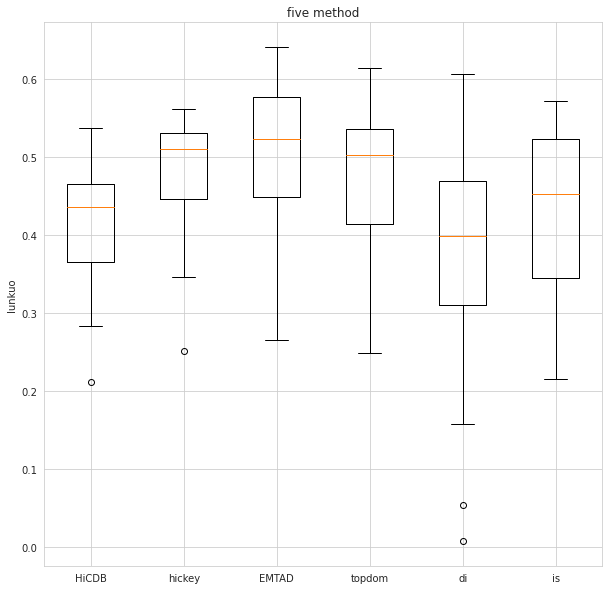

In [197]:
# 五个list画图
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 五个lunkuo的list画图
em_lunkuo = np.array(em_lunkuo)
hickey_lunkuo = np.array(hickey_lunkuo)
HiCDB_lunkuo = np.array(HiCDB_lunkuo)
topdom_lunkuo = np.array(topdom_lunkuo)
di_lunkuo = np.array(di_lunkuo)
is_lunkuo = np.array(is_lunkuo)

# 绘制boxplt
plt.figure(figsize=(10,10))
plt.boxplot([em_lunkuo,hickey_lunkuo,HiCDB_lunkuo,topdom_lunkuo,di_lunkuo,is_lunkuo],labels=['HiCDB','hickey','EMTAD','topdom','di','is'])
plt.title('six method')
plt.ylabel('lunkuo')
plt.show()


In [199]:
import networkx as nx
from networkx.algorithms import community

def calculate_modularity(adjacency_matrix, labels):
    # 创建无向图对象
    adjacency_matrix_norm = adjacency_matrix / np.max(adjacency_matrix)
    G=nx.from_numpy_matrix(adjacency_matrix_norm)

    # 计算模块度
    partition = []
    unique_labels = sorted(np.unique(labels))
    for i in range(len(unique_labels)):
        lb = unique_labels[i]
        idx = np.where(labels == lb)[0]
        partition.append(set(idx))
    modularity = community.modularity(G, partition)
    return modularity

def get_tad_label(bd_list,mat_len):
    # 创建一个mat_len大小的全为-1的list
    label_list = np.zeros(mat_len, dtype=np.int)
    begin = 0
    for boundary in bd_list:
        label_list[begin:boundary] = begin
        begin = boundary
    return label_list

def compare_celline_modularity(mat_folder, results, mat_length_list,celline):
    value_list = []
    for index in range(len(results)):
        mat = np.loadtxt("{0}/{1}{2}".format(mat_folder,celline,index+1))
        tad_label = get_tad_label(results[index], mat_length_list[index])
        value = calculate_modularity(mat, tad_label)
        value_list.append(value)
    return value_list

In [200]:
HiCDB_mokuai = compare_celline_modularity('/mnt/disk1/duanran/{0}dense'.format(celline), HiCDB_result_list, mat_len_list,celline)
hickey_mokuai = compare_celline_modularity('/mnt/disk1/duanran/{0}dense'.format(celline), hickey_result_list, mat_len_list,celline)
em_mokuai = compare_celline_modularity('/mnt/disk1/duanran/{0}dense'.format(celline), EMtad_result_list, mat_len_list,celline)
topdom_mokuai = compare_celline_modularity('/mnt/disk1/duanran/{0}dense'.format(celline), topdom_result_list, mat_len_list,celline)
di_mokuai = compare_celline_modularity('/mnt/disk1/duanran/{0}dense'.format(celline), di_result_list, mat_len_list,celline)
is_mokuai = compare_celline_modularity('/mnt/disk1/duanran/{0}dense'.format(celline), is_result_list, mat_len_list,celline)

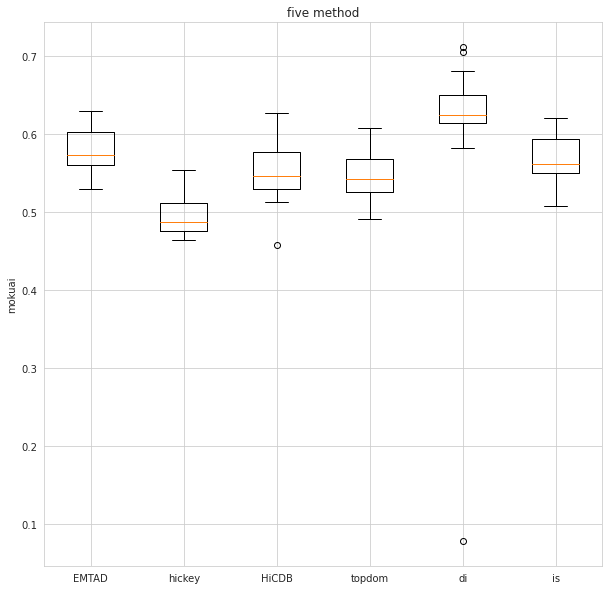

In [201]:
# 画五个mokuai的list画图
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 五个mokuai的list画图
em_mokuai = np.array(em_mokuai)
hickey_mokuai = np.array(hickey_mokuai)
HiCDB_mokuai = np.array(HiCDB_mokuai)
topdom_mokuai = np.array(topdom_mokuai)
di_mokuai = np.array(di_mokuai)
is_mokuai = np.array(is_mokuai)

# 绘制boxplt
plt.figure(figsize=(10,10))
plt.boxplot([em_mokuai,hickey_mokuai,HiCDB_mokuai,topdom_mokuai,di_mokuai,is_mokuai],labels=['EMTAD','hickey','HiCDB','topdom','di','is'])
plt.title('five method')
plt.ylabel('mokuai')
plt.show()
